**ICPS PROJECT- CLASSIFICATION OF SHIPS**

**NEEDED LIBRARIES**

In [41]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import IPython.display as ipd

**CREATING A DATAFRAME**

In [42]:
Regex = re.compile(r'\d{1,3}.wav')
path='/content/drive/MyDrive/DeepShip-main/'
# Construct file path by concatenating fold and file name
df = pd.DataFrame(columns=["relative_path","classID"])
df.head()

,relative_path,classID


In [43]:
directory = "/content/drive/MyDrive/DeepShip-main/"

for root, subdirectories, files in os.walk(directory):
    for subdirectory in subdirectories:
        folder=os.path.join(root, subdirectory)
        for file in os.listdir(folder):
          if Regex.search(file):
            x=pd.DataFrame(["/"+str(subdirectory)+"/"+str(file),str(subdirectory)]).transpose()
            x.columns=["relative_path","classID"]
            df = pd.concat([df,x],axis=0)

In [44]:

df.reset_index(inplace=True)

In [45]:
df.head()

,index,relative_path,classID
0,0,/Passengership/23.wav,Passengership
1,0,/Passengership/1.wav,Passengership
2,0,/Passengership/41.wav,Passengership
3,0,/Passengership/9.wav,Passengership
4,0,/Passengership/29.wav,Passengership


In [46]:
df.drop(["index"],inplace=True,axis=1)

In [47]:
df.head()

,relative_path,classID
0,/Passengership/23.wav,Passengership
1,/Passengership/1.wav,Passengership
2,/Passengership/41.wav,Passengership
3,/Passengership/9.wav,Passengership
4,/Passengership/29.wav,Passengership


**CREATING CATEGORIES INTO ARRAY**

In [48]:
df['classID'].unique()

array(['Passengership', 'Tanker', 'Cargo', 'Tug'], dtype=object)

**PRE-PROCESSING**

In [49]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['classID']= label_encoder.fit_transform(df['classID'])
  
df['classID'].unique()

array([1, 2, 0, 3])

In [50]:
df.head()

,relative_path,classID
0,/Passengership/23.wav,1
1,/Passengership/1.wav,1
2,/Passengership/41.wav,1
3,/Passengership/9.wav,1
4,/Passengership/29.wav,1


In [51]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
    # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
    # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
    # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
  
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [52]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

**SPLITTING**

In [53]:
from torch.utils.data import random_split

myds = SoundDS(df, path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders  batch_size=5,
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=5, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=5, shuffle=False)

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**CNN MODEL IMPLEMENTATION**

In [55]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [56]:
from torch.utils.data import Dataset

**LOOPING TRAINING DATA**

In [57]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # print(i)
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=8   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 2.33, Accuracy: 0.04
Epoch: 1, Loss: 2.32, Accuracy: 0.06
Epoch: 2, Loss: 2.28, Accuracy: 0.22
Epoch: 3, Loss: 2.18, Accuracy: 0.36
Epoch: 4, Loss: 2.05, Accuracy: 0.48
Epoch: 5, Loss: 2.10, Accuracy: 0.42
Epoch: 6, Loss: 2.07, Accuracy: 0.38
Epoch: 7, Loss: 2.00, Accuracy: 0.48
Finished Training


**PREDICTION**

In [58]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.23, Total items: 13


In [59]:
classes = {0:'Cargo',1:'Passengership',2:'Tanker',3:'Tug'}

**ANN IMPLEMENTATION**

In [60]:
import librosa as lb

In [61]:
def feature_extractor(path):
    data, simple_rate = lb.load(path)
    data = lb.feature.mfcc(data,n_mfcc=128)
    data = np.mean(data,axis=1)
    return data

In [62]:
from tqdm import tqdm

In [63]:
x, y = [], []
for i,rows in tqdm(df.iterrows()):
    path = '/content/drive/MyDrive/DeepShip-main'  + '/' + str(rows['relative_path'])
    x.append(feature_extractor(path))
    y.append(rows['classID'])
x = np.array(x)
y = np.array(y)
x.shape, y.shape

63it [02:57,  2.82s/it]


((63, 128), (63,))

In [64]:
from tensorflow import keras

In [65]:
from tensorflow.keras.utils import to_categorical

In [66]:
y = to_categorical(y)
y.shape

(63, 4)

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
xtrainval, xtest, ytrainval, ytest = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])


Number of samples for Train set : 44
Number of samples for Validation set : 12
Number of samples for Test set : 7


In [69]:
from tensorflow.keras import Sequential, layers

In [70]:
# ANN model
model = Sequential(
                        [
                            layers.Dense(1000,activation='relu',input_shape=(128,)),# first layer
                            layers.Dense(128,activation='relu'),# hidden layer 1 with 128 neurons
                            # layers.Dense(500,activation='relu'),
                            # layers.Dense(250,activation='relu'),
                            # layers.Dense(100,activation='relu'),
                            # layers.Dense(50,activation='relu'),
                            layers.Dense(4,activation='softmax') #output layer
                        ]
                   )
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1000)              129000    
                                                                 
 dense_15 (Dense)            (None, 128)               128128    
                                                                 
 dense_16 (Dense)            (None, 4)                 516       
                                                                 
Total params: 257,644
Trainable params: 257,644
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
2/2 [==============================] - 1s 190ms/step - loss: 15.0696 - accuracy: 0.3409 - val_loss: 39.1349 - val_accuracy: 0.1667
Epoch 2/20
2/2 [==============================] - 0s 32ms/step - loss: 34.2051 - accuracy: 0.2045 - val_loss: 25.3730 - val_accuracy: 0.4167
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 21.1033 - accuracy: 0.4545 - val_loss: 3.0895 - val_accuracy: 0.4167
Epoch 4/20
2/2 [==============================] - 0s 51ms/step - loss: 8.3236 - accuracy: 0.3864 - val_loss: 20.5062 - val_accuracy: 0.3333
Epoch 5/20
2/2 [==============================] - 0s 30ms/step - loss: 23.2016 - accuracy: 0.3182 - val_loss: 15.4804 - val_accuracy: 0.0833
Epoch 6/20
2/2 [==============================] - 0s 29ms/step - loss: 16.1548 - accuracy: 0.0455 - val_loss: 2.4671 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 0s 32ms/step - loss: 4.6510 - accuracy: 0.4773 - val_loss: 10.5527 - val_accuracy: 0.4167
Epoch 8/20
2/2 [

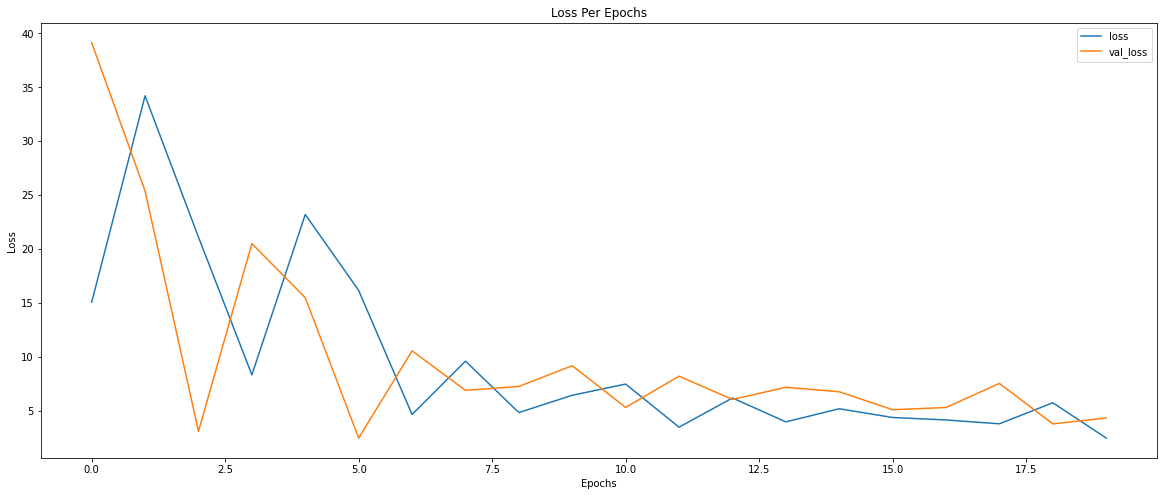

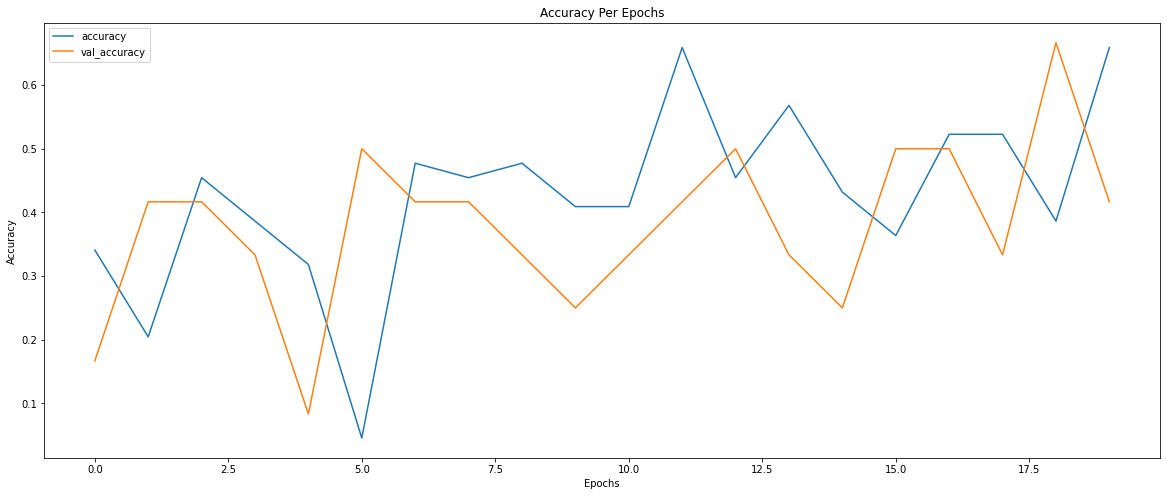

1/1 [==============================] - 0s 57ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix :


[[2 0 0]
 [0 0 2]
 [1 0 2]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.50      0.67      0.57         3

    accuracy                           0.57         7
   macro avg       0.39      0.56      0.46         7
weighted avg       0.40      0.57      0.47         7

1/1 [==============================] - 0s 23ms/step
Class predicted : Tanker 




In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
training = model.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=20)
train_hist = pd.DataFrame(training.history)
train_hist
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
ytrue = np.argmax(ytest,axis=1)
ypred = np.argmax(model.predict(xtest),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))
import IPython.display as ipd
def predict(path):
    audio = np.array([feature_extractor(path)])
    classid = np.argmax(model.predict(audio)[0])
    print('Class predicted :',classes[classid],'\n\n')
    return ipd.Audio(path)
predict('../content/drive/MyDrive/DeepShip-main/Cargo/103.wav')


In [80]:
# ANN model
model = Sequential(
                        [
                            layers.Dense(1000,activation='relu',input_shape=(128,)),# first layer
                            layers.Dense(64,activation='relu'),# hidden layer 1 with 64 neurons
                            # layers.Dense(500,activation='relu'),
                            # layers.Dense(250,activation='relu'),
                            # layers.Dense(100,activation='relu'),
                            # layers.Dense(50,activation='relu'),
                            layers.Dense(4,activation='softmax') #output layer
                        ]
                   )
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1000)              129000    
                                                                 
 dense_29 (Dense)            (None, 64)                64064     
                                                                 
 dense_30 (Dense)            (None, 4)                 260       
                                                                 
Total params: 193,324
Trainable params: 193,324
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
2/2 [==============================] - 1s 196ms/step - loss: 13.1952 - accuracy: 0.2500 - val_loss: 10.2400 - val_accuracy: 0.0833
Epoch 2/20
2/2 [==============================] - 0s 27ms/step - loss: 9.9859 - accuracy: 0.1591 - val_loss: 11.5179 - val_accuracy: 0.3333
Epoch 3/20
2/2 [==============================] - 0s 27ms/step - loss: 10.6175 - accuracy: 0.3182 - val_loss: 11.8487 - val_accuracy: 0.4167
Epoch 4/20
2/2 [==============================] - 0s 28ms/step - loss: 9.9811 - accuracy: 0.4545 - val_loss: 9.9419 - val_accuracy: 0.4167
Epoch 5/20
2/2 [==============================] - 0s 30ms/step - loss: 7.0986 - accuracy: 0.4091 - val_loss: 7.8285 - val_accuracy: 0.3333
Epoch 6/20
2/2 [==============================] - 0s 28ms/step - loss: 5.5034 - accuracy: 0.3864 - val_loss: 6.0743 - val_accuracy: 0.1667
Epoch 7/20
2/2 [==============================] - 0s 27ms/step - loss: 3.9516 - accuracy: 0.2727 - val_loss: 6.5296 - val_accuracy: 0.4167
Epoch 8/20
2/2 [=====

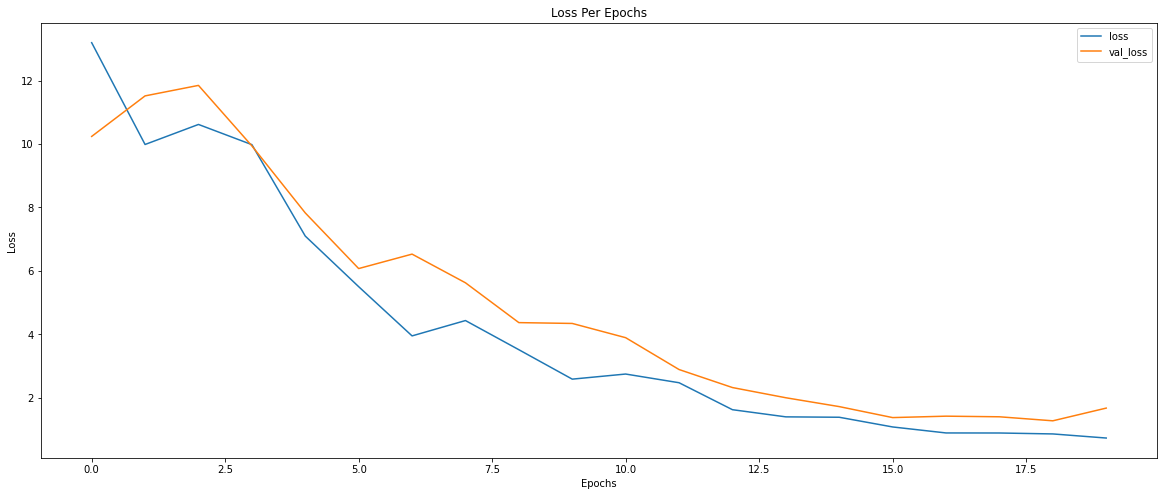

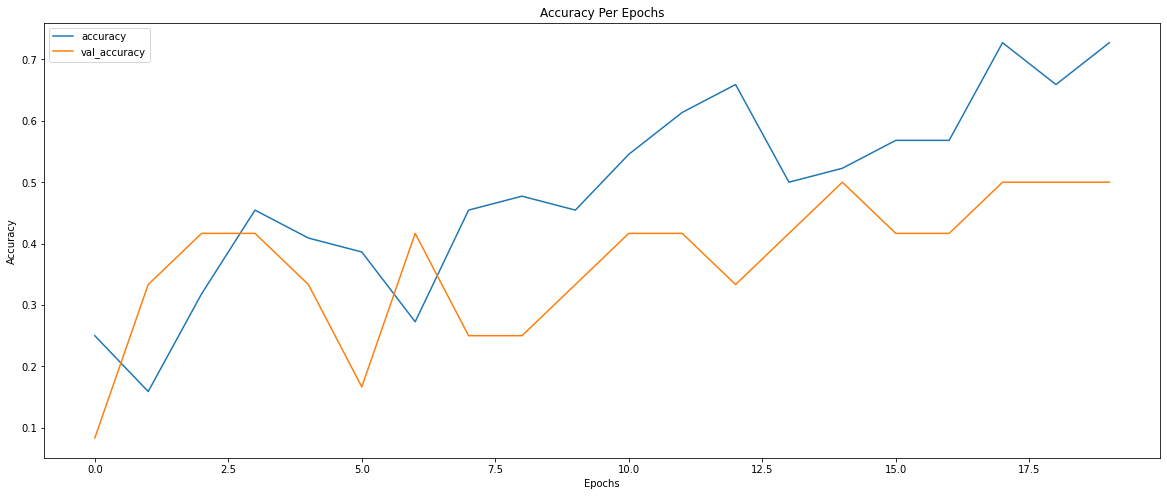


Number of samples for Train set : 44
Number of samples for Validation set : 12
Number of samples for Test set : 7
1/1 [==============================] - 0s 62ms/step
Class predicted : Tanker 




In [81]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
training = model.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=20)
train_hist = pd.DataFrame(training.history)
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

xtrainval, xtest, ytrainval, ytest = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])
def predict(path):
    audio = np.array([feature_extractor(path)])
    classid = np.argmax(model.predict(audio)[0])
    print('Class predicted :',classes[classid],'\n\n')
    return ipd.Audio(path)
predict('../content/drive/MyDrive/DeepShip-main/Cargo/103.wav')


In [82]:

model = Sequential(
                        [
                            layers.Dense(1000,activation='relu',input_shape=(128,)),# first layer
                            layers.Dense(128,activation='relu'),# hidden layer 1 
                            layers.Dense(128,activation='relu'),# hidden layer 2
                            # layers.Dense(250,activation='relu'),
                            # layers.Dense(100,activation='relu'),
                            # layers.Dense(50,activation='relu'),
                            layers.Dense(4,activation='softmax') #output layer
                        ]
                   )
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 1000)              129000    
                                                                 
 dense_32 (Dense)            (None, 128)               128128    
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dense_34 (Dense)            (None, 4)                 516       
                                                                 
Total params: 274,156
Trainable params: 274,156
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
2/2 [==============================] - 2s 686ms/step - loss: 15.1049 - accuracy: 0.3636 - val_loss: 9.9346 - val_accuracy: 0.1667
Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 10.4820 - accuracy: 0.1364 - val_loss: 6.6404 - val_accuracy: 0.4167
Epoch 3/20
2/2 [==============================] - 0s 53ms/step - loss: 5.8765 - accuracy: 0.4545 - val_loss: 1.6348 - val_accuracy: 0.2500
Epoch 4/20
2/2 [==============================] - 0s 66ms/step - loss: 2.1052 - accuracy: 0.2045 - val_loss: 3.9694 - val_accuracy: 0.3333
Epoch 5/20
2/2 [==============================] - 0s 101ms/step - loss: 3.2252 - accuracy: 0.3636 - val_loss: 2.1320 - val_accuracy: 0.3333
Epoch 6/20
2/2 [==============================] - 0s 67ms/step - loss: 1.9002 - accuracy: 0.4545 - val_loss: 2.6003 - val_accuracy: 0.4167
Epoch 7/20
2/2 [==============================] - 0s 60ms/step - loss: 2.3915 - accuracy: 0.3182 - val_loss: 1.5330 - val_accuracy: 0.4167
Epoch 8/20
2/2 [=======

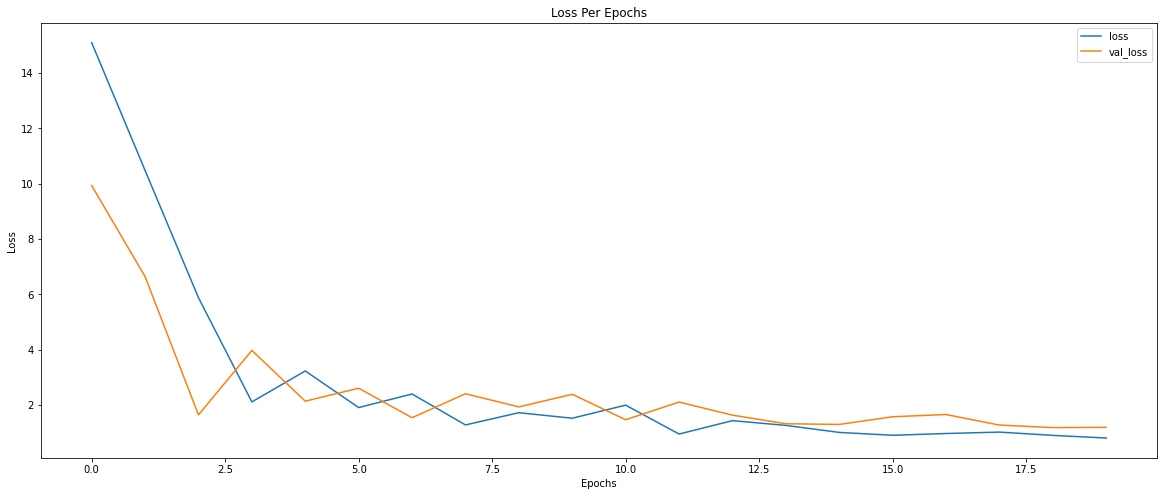

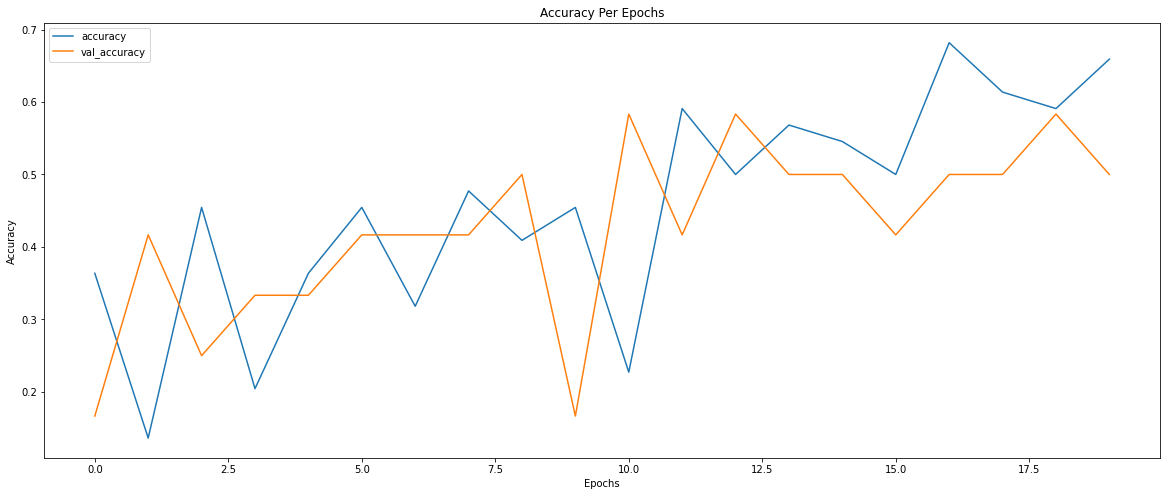


Number of samples for Train set : 44
Number of samples for Validation set : 12
Number of samples for Test set : 7
1/1 [==============================] - 0s 101ms/step
Class predicted : Cargo 




In [83]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
training = model.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=20)
train_hist = pd.DataFrame(training.history)
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

xtrainval, xtest, ytrainval, ytest = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])
def predict(path):
    audio = np.array([feature_extractor(path)])
    classid = np.argmax(model.predict(audio)[0])
    print('Class predicted :',classes[classid],'\n\n')
    return ipd.Audio(path)
predict('../content/drive/MyDrive/DeepShip-main/Cargo/103.wav')


In [88]:

model = Sequential(
                        [
                            layers.Dense(1000,activation='relu',input_shape=(128,)),# first layer
                            layers.Dense(64,activation='relu'),# hidden layer 1 
                            layers.Dense(64,activation='relu'),# hidden layer 2
                            # layers.Dense(250,activation='relu'),
                            # layers.Dense(100,activation='relu'),
                            # layers.Dense(50,activation='relu'),
                            layers.Dense(4,activation='softmax') #output layer
                        ]
                   )
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 1000)              129000    
                                                                 
 dense_40 (Dense)            (None, 64)                64064     
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 dense_42 (Dense)            (None, 4)                 260       
                                                                 
Total params: 197,484
Trainable params: 197,484
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
2/2 [==============================] - 2s 445ms/step - loss: 8.2119 - accuracy: 0.3636 - val_loss: 17.8125 - val_accuracy: 0.0833
Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 17.2590 - accuracy: 0.0909 - val_loss: 5.7971 - val_accuracy: 0.1667
Epoch 3/20
2/2 [==============================] - 0s 79ms/step - loss: 5.3099 - accuracy: 0.2500 - val_loss: 2.9779 - val_accuracy: 0.4167
Epoch 4/20
2/2 [==============================] - 0s 85ms/step - loss: 3.2866 - accuracy: 0.3409 - val_loss: 4.1739 - val_accuracy: 0.3333
Epoch 5/20
2/2 [==============================] - 0s 47ms/step - loss: 3.8737 - accuracy: 0.3636 - val_loss: 4.7724 - val_accuracy: 0.4167
Epoch 6/20
2/2 [==============================] - 0s 44ms/step - loss: 3.6120 - accuracy: 0.4545 - val_loss: 1.8932 - val_accuracy: 0.6667
Epoch 7/20
2/2 [==============================] - 0s 50ms/step - loss: 1.9555 - accuracy: 0.4545 - val_loss: 2.7052 - val_accuracy: 0.3333
Epoch 8/20
2/2 [========

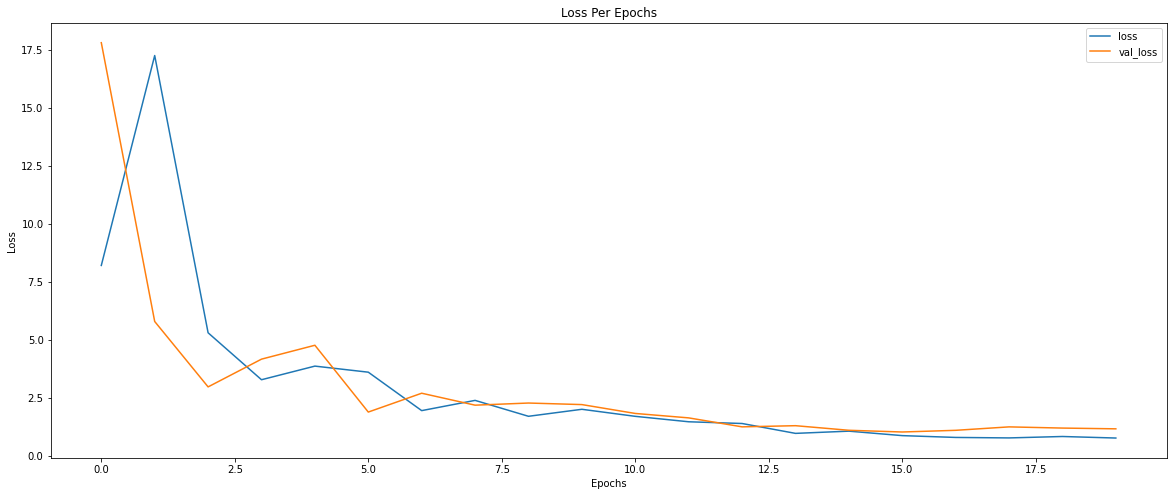

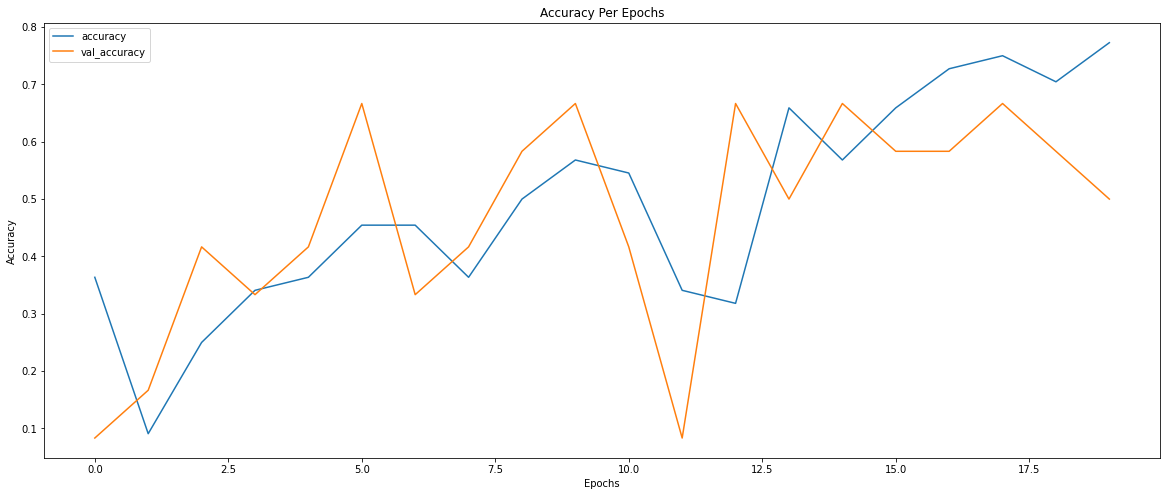


Number of samples for Train set : 44
Number of samples for Validation set : 12
Number of samples for Test set : 7
1/1 [==============================] - 0s 63ms/step
Class predicted : Cargo 




In [89]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
training = model.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=20)
train_hist = pd.DataFrame(training.history)
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

xtrainval, xtest, ytrainval, ytest = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])
def predict(path):
    audio = np.array([feature_extractor(path)])
    classid = np.argmax(model.predict(audio)[0])
    print('Class predicted :',classes[classid],'\n\n')
    return ipd.Audio(path)
predict('../content/drive/MyDrive/DeepShip-main/Cargo/103.wav')


In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [91]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
model.fit(xtrain, ytrain)
preds = model.predict(xtest)
print('Accuracy:', round(accuracy_score(ytest, preds)))

Accuracy: 0
